In [1]:
from transformers import AutoModelForMaskedLM, TrainingArguments, Trainer, AutoTokenizer
import torch

from lava import LavaModelSmall
model = LavaModelSmall.from_lava_pretrained('roberta-base', 'facebook/bart-base')

from utils.datasets_config import get_dataset

dset = get_dataset('gigaword', 'facebook/bart-base')
print(dset)

tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')




Some weights of BartForQuestionAnswering were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You passed along `num_labels=3` with an incompatible id to label map: {0: 'LABEL_0', 1: 'LABEL_1'}. The number of labels wil be overwritten to 2.
Found cached dataset gigaword (/home/ruihan/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/ruihan/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-ec2f04cbc5a64a59.arrow
Loading cached processed dataset at /home/ruihan/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-f10e57b03c68e54b.arrow
Loading cached processed dataset at /home/ruihan/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-b8e4fbcfe3300933.arrow


Number of gigaword training examples: 3803957
Number of gigaword validation examples: 189651
Number of gigaword testing examples: 1951
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'input_texts', 'label_texts'],
        num_rows: 3803957
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'input_texts', 'label_texts'],
        num_rows: 189651
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'input_texts', 'label_texts'],
        num_rows: 1951
    })
})


In [2]:
training_args = TrainingArguments(
    # evaluation_strategy = "steps",
    output_dir= 'lava-ce',
    overwrite_output_dir=True,
    num_train_epochs=1,
    max_steps = 700_000,
    per_device_train_batch_size=4,
    save_steps=5_000,
    save_total_limit=20,
    prediction_loss_only=True,
    dataloader_num_workers=4,
    # learning_rate=3e-4,
    # logging_steps = 5,
    # eval_steps = 5,
    # metric_for_best_model = 'f1',
    # load_best_model_at_end=True,
)


In [3]:
tokenizer.convert_ids_to_tokens(2
                    )

'</s>'

In [4]:
def collate(batch):
    batch = ({k: torch.nn.utils.rnn.pad_sequence([dic[k] for dic in batch], batch_first=True, padding_value=1) for k in batch[0]})
    batch['input_ids'][batch['input_ids'] == 2] = 0
    batch['attention_mask'] = (batch['input_ids'] != 1).long()
    batch['labels'][batch['labels']==1] = -100
#     batch['labels'] = torch.nn.functional.pad(batch['labels'], (0, batch['input_ids'].shape[1] - batch['labels'].shape[1], 0, 0), 'constant', 1)
    return batch

In [5]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = dset['train'].shuffle(1234),
    eval_dataset = dset['test'].shard(30, 1),
    data_collator = collate,
    # compute_metrics = lambda x: print(x),
    # callbacks = [EarlyStoppingCallback(early_stopping_patience=7)],
)


Loading cached shuffled indices for dataset at /home/ruihan/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-b72e92e25248f7d5.arrow
max_steps is given, it will override any value given in num_train_epochs


In [6]:
trainer._load_from_checkpoint('lava-ce/checkpoint-35000')

Loading model from lava-ce/checkpoint-35000.


In [7]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `LavaModelSmall.forward` and have been ignored: input_texts, label_texts. If input_texts, label_texts are not expected by `LavaModelSmall.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 65
  Batch size = 8


{'eval_loss': 3.8911497592926025,
 'eval_runtime': 1.2784,
 'eval_samples_per_second': 50.844,
 'eval_steps_per_second': 7.04}

In [8]:
d = next(iter(dset['train'].shard(300, 1).shuffle()))
decoder_input_ids = (d['labels'] == 1).long()

Loading cached shuffled indices for dataset at /home/ruihan/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-92e797154ba25e06.arrow


In [9]:
o = model(
    input_ids = d['input_ids'].cuda().unsqueeze(0),
    attention_mask = d['attention_mask'].cuda().unsqueeze(0),
)

In [10]:
d

{'input_ids': tensor([    0,   397, 17419, 10409,    34,  4768,   690,    14,   169,   858,
          4533,  6071,    40,    28,  1088,    11,     5, 10408, 16705,  2937,
          2931,  1437,  1437,   511, 18898,  6116,    59,     5,  5955,  1437,
           579,   499,    23,     5,   950,  1437,  1437,     2]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'labels': tensor([    0, 33557,  9118,   708,     7,  1331,  4533,  6071,     2])}

In [11]:
o.logits.argmax(2)

tensor([[    7, 12196, 17419,   849,    34,    10,   849,  1437,  1437,  1437,
          4533,     8,    40,    28,  1088,    11,     5,  1437,     9,  1437,
          1437,  1437,  1437,  1437,     8,  1437,     9,     5,  1437,  1437,
           579,  1437,    23,     5,   950,  1437,  1437,     2,     0]],
       device='cuda:0')

In [12]:
tokenizer.decode(o.logits.argmax(2).tolist()[0], skip_special_tokens=False)


' towhatchester # has a #    ro and will be sold in the  of      and  of the   s  at the club  </s><s>'

In [13]:
print(tokenizer.decode(d['input_ids'], skip_special_tokens=True))
print()
print(tokenizer.decode(d['labels'], skip_special_tokens=True))

manchester united has dismissed reports that wayne rooney will be sold in the january transfer window   following rampant speculation about the striker  s future at the club  

united denies plans to sell rooney


In [14]:
scores = model.decoder(input_ids = d['input_ids'].cuda().unsqueeze(0), decoder_input_ids = 50264 * torch.ones_like(d['input_ids']).cuda().unsqueeze(0)).end_logits
scores

tensor([[-0.0774, -1.8899, -1.8205, -0.8274, -0.5692, -0.6887, -1.3088, -1.3962,
         -1.4535, -1.4825, -1.4891, -1.4532, -1.4254, -1.4702, -1.3869, -1.4234,
         -1.3903, -1.3698, -1.4222, -1.3819, -1.4039, -1.2901, -1.2907, -1.2471,
         -1.2690, -1.3178, -1.3961, -1.2551, -1.2722, -1.2860, -1.2770, -1.3191,
         -1.2959, -1.2438, -1.2295, -1.2728, -1.3323, -1.3380]],
       device='cuda:0', grad_fn=<CloneBackward0>)

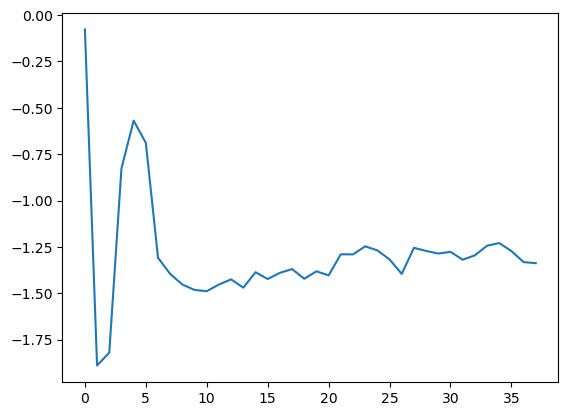

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(scores.tolist()[0])

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 142,817,625 trainable parameters


In [21]:
model.decoder(input_ids = d['input_ids'].cuda().unsqueeze(0), decoder_input_ids = 50264 * torch.ones_like(d['input_ids']).cuda().unsqueeze(0)).end_logits

tensor([[-0.0774, -1.8899, -1.8205, -0.8274, -0.5692, -0.6887, -1.3088, -1.3962,
         -1.4535, -1.4825, -1.4891, -1.4532, -1.4254, -1.4702, -1.3869, -1.4234,
         -1.3903, -1.3698, -1.4222, -1.3819, -1.4039, -1.2901, -1.2907, -1.2471,
         -1.2690, -1.3178, -1.3961, -1.2551, -1.2722, -1.2860, -1.2770, -1.3191,
         -1.2959, -1.2438, -1.2295, -1.2728, -1.3323, -1.3380]],
       device='cuda:0', grad_fn=<CloneBackward0>)